In [1]:
import json
import pandas as pd
import os
from vega import VegaLite
%run utils

benchmark_dir = "../benchmarks"

def load_input_table(fname):
    with open(os.path.join(benchmark_dir, fname), "r") as f:
        benchmark = json.load(f)
        input_data = benchmark["input_data"]
        df = pd.DataFrame.from_records(input_data)
        df = load_and_clean_table(df)
        return df

   Actual Profits  Number of Units   Quarter
0            3358               23  Quarter1
1            3829               27  Quarter2
2            2374               15  Quarter3
3            3373               43  Quarter4


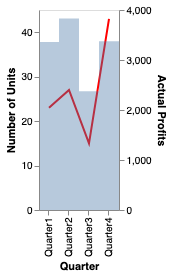

In [2]:
df1 = load_input_table("001.json")

#df = pd.melt(df, id_vars='Quarter', value_vars=["Actual Profits", "No. of Units"])

print(df1)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Quarter", "type": "nominal" }
    },
    "layer": [
        {
            "mark": {"stroke": "red", "type": "line"},
            "encoding": {
                "y": {"field": "Number of Units", "type": "quantitative"}
            }
        }, 
        {
            "mark": {"opacity": 0.4, "type": "bar"},
            "encoding": {
                "y": {"type": "quantitative", "field": "Actual Profits"}
            }
        }
  ],
  "resolve": {"scale": {"y": "independent"}}
}, df1)

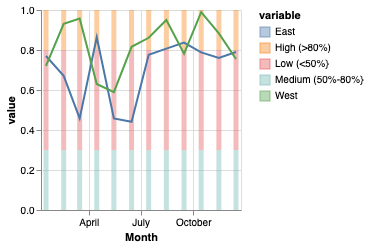

In [3]:
df2 = load_input_table("002.json")

df2_0 = pd.melt(df2, id_vars='Month', value_vars=["Low (<50%}", "Medium (50%-80%}", "High (>80%)", "East", "West"])

#print(df2_0)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Month", "type": "temporal" }
    },
    "layer": [
        {
            "mark": {"opacity": 0.4, "type": "bar"},
            "transform": [{"filter": "datum.variable != \"East\" && datum.variable != \"West\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        }, 
        {
            "mark": {"type": "line", "stroke": "red"},
            "transform": [{"filter": "datum.variable == \"East\" || datum.variable == \"West\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        }
  ]
}, df2_0)

    Month  Net Cash Flow  Net Cash Flow Sum       c      d
0   Start          80000              80000       0  False
1     Apr          -5003              74997   80000   True
2     May         -16700              58297   74997   True
3     Jun          48802             107099   58297  False
4     Jul         -11198              95901  107099   True
5     Aug         -35260              60641   95901   True
6     Sep          18220              78861   60641  False
7     Oct         -23840              55021   78861   True
8     Nov          43250              98271   55021  False
9     Dec         -18280              79991   98271   True
10    Jan          26670             106661   79991  False
11    Feb          15000             121661  106661  False
12    Mar          24750             146411  121661  False


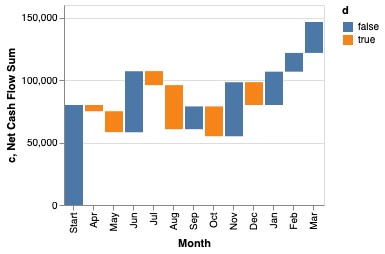

In [4]:
df3 = load_input_table("003.json")

df3_1 = df3["Net Cash Flow"].cumsum()
df3 = df3.join(df3_1, lsuffix='', rsuffix=' Sum')
df3 = df3.assign(c=df3["Net Cash Flow Sum"]-df3["Net Cash Flow"])
df3 = df3.assign(d=df3["c"]>df3["Net Cash Flow Sum"])

print(df3)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {"field": "Month", "type": "nominal", "sort": "none"},
        "y2": {
          "field": "Net Cash Flow Sum",
          "type": "quantitative"    
        },
        "y": {"field": "c", "type": "quantitative"},
        "color": {"field": "d", "type": "nominal"},
    }
}, df3)

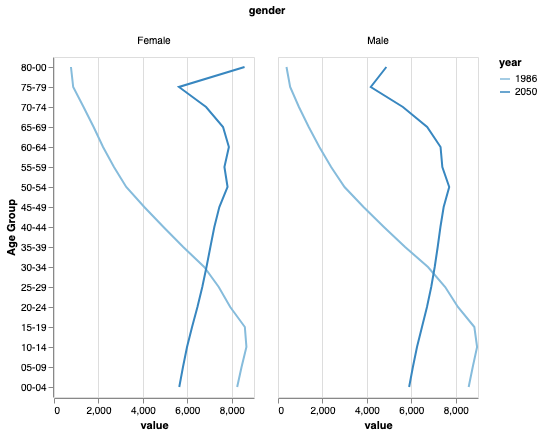

In [5]:
df4 = load_input_table("004.json")

df4 = pd.melt(df4, id_vars='Age Group', value_vars=["Female-1986", "Female-2050", "Male-1986", "Male-2050"])

split_col = df4["variable"].str.split("-", expand=True)
df4["gender"] = split_col[0]
df4["year"] = split_col[1]

#print(df4)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "y": {"field": "Age Group", "type": "nominal", "sort": "descending"},
        "x": {
          "field": "value",
          "type": "quantitative"    
        },
        "column": {"field": "gender", "type": "nominal"},
        "color": {"field": "year","type": "ordinal"},
    }
}, df4)

   Month variable    value
0    Jan     Cost   6.0000
1    Feb     Cost  15.0000
2    Mar     Cost  24.0000
3    Apr     Cost  33.0000
4    May     Cost  42.0000
5    Jun     Cost  51.0000
6    Jan   Profit   4.0000
7    Feb   Profit   5.0000
8    Mar   Profit   6.0000
9    Apr   Profit   7.0000
10   May   Profit   8.0000
11   Jun   Profit   9.0000
12   Jan      ROI   0.6667
13   Feb      ROI   0.3333
14   Mar      ROI   0.2500
15   Apr      ROI   0.2121
16   May      ROI   0.1905
17   Jun      ROI   0.1765
18   Jan    Sales  10.0000
19   Feb    Sales  20.0000
20   Mar    Sales  30.0000
21   Apr    Sales  40.0000
22   May    Sales  50.0000
23   Jun    Sales  60.0000


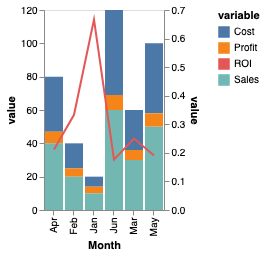

In [6]:
df5 = load_input_table("005.json")

df5 = pd.melt(df5, id_vars='Month', value_vars=["Cost", "Profit", "ROI", "Sales"])

print(df5)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Month", "type": "nominal" }
    },
    "layer": [
        {
            "mark": {"type": "bar"},
            "transform": [{"filter": "datum.variable != \"ROI\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        },
        {
            "mark": {"type": "line", "stroke": "red"},
            "transform": [{"filter": "datum.variable == \"ROI\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        }
  ],
  "resolve": {"scale": {"y": "independent"}}
}, df5)

     Bucket  variable  value
0  Bucket E    Actual    115
1  Bucket D    Actual     90
2  Bucket C    Actual    115
3  Bucket B    Actual    140
4  Bucket A    Actual    150
5  Bucket E  Budgeted    100
6  Bucket D  Budgeted    100
7  Bucket C  Budgeted    125
8  Bucket B  Budgeted    125
9  Bucket A  Budgeted    140


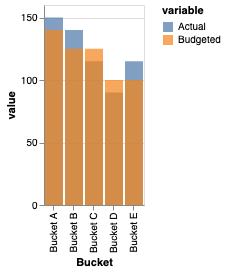

In [7]:
df6 = load_input_table("006.json")

df6 = pd.melt(df6, id_vars='Bucket', value_vars=["Actual", "Budgeted"])

print(df6)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "transform": [{"filter": "datum.variable != \"ROI\""}],
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "value", "type": "quantitative", "stack": "null"},
        "x": { "field": "Bucket", "type": "nominal" },
        "opacity": {"value": 0.7}
    }
}, df6)

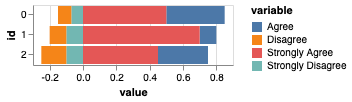

In [8]:
df7 = load_input_table("007.json")

df7['id'] = df7.index
df7 = pd.melt(df7, id_vars='id', value_vars=["Strongly Disagree", "Agree", "Disagree", "Strongly Agree"])
df7['value'].mask(df7['variable'] == "Disagree", -df7["value"], inplace=True)
df7['value'].mask(df7['variable'] == "Strongly Disagree", -df7["value"], inplace=True)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "id", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative"}    
    }
}, df7)

Value variable  lower range  means  stddev  upper range
0           Y1         0.39   0.52  0.1328         0.66
1           Y2         0.44   0.57  0.1321         0.70
2           Y3         0.47   0.60  0.1303         0.73
3           Y4         0.50   0.63  0.1266         0.75
4           Y5         0.51   0.63  0.1225         0.75


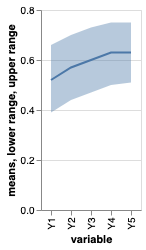

In [9]:
df8 = load_input_table("008.json")

# gather(dat, "col1", "col2", -Value) %>% spread(Value, col2)
df8 = pd.melt(df8, id_vars='Value', value_vars=["Y1", "Y2", "Y3", "Y4", "Y5"])
df8 = df8.pivot(index='variable',columns='Value', values='value').reset_index()
df8 = load_and_clean_table(df8)

print(df8)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "variable", "type": "nominal" }
    },
    "layer": [
        {
            "mark": "line",
            "encoding": {
                "y": {"field": "means", "type": "quantitative"}
            }
        }, 
        {
            "mark": {"opacity": 0.4, "type": "area"},
            "encoding": {
                "y": {"type": "quantitative", "field": "lower range"},
                "y2": {"type": "quantitative", "field": "upper range"}
            }
        }
  ]
}, df8)

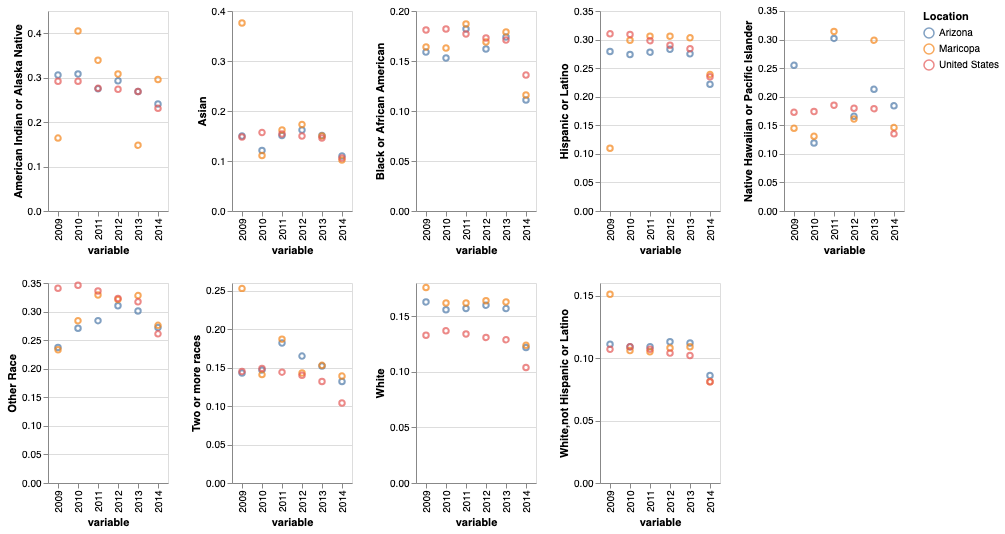

In [10]:
df9 = load_input_table("009.json")
df9 = pd.melt(df9, id_vars=['Location', 'Rae'], value_vars=["2009", "2010", "2011", "2012", "2013", "2014"])
df9 = df9.pivot_table(index=["Location", "variable"], columns='Rae', values='value').reset_index()

#print(df9)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "repeat": ["American Indian or Alaska Native", "Asian", "Black or African American", 
               "Hispanic or Latino", "Native Hawaiian or Pacific Islander", "Other Race",
               "Two or more races", "White", "White,not Hispanic or Latino"],
    "columns": 5,
  "spec": {
    "encoding": {
        "x": { "field": "variable", "type": "nominal" }
    },
    "layer": [
        {
            "mark": "point",
            "encoding": {
                "y": {"field": {"repeat": "repeat"}, "type": "quantitative"},
                "color": {"field": "Location", "type": "nominal"}
            }
        }
    ]
  }
}, df9)

      Class variable  value
0  Literacy     Fall     34
1  Language     Fall     63
2      Math     Fall     67
3   Science     Fall     92
4      Arts     Fall     96
5  Literacy   Spring     69
6  Language   Spring     77
7      Math   Spring     75
8   Science   Spring     98
9      Arts   Spring    100


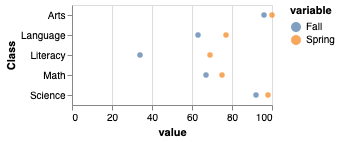

In [11]:
df10 = load_input_table("010.json")
df10 = pd.melt(df10, id_vars="Class", value_vars=['Fall', 'Spring'])

print(df10)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "y": {"field": "Class", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative" },
        "color": {"field": "variable", "type": "nominal"}
    }

}, df10)

C1       variable        C2    Q1    Q2    Q3
0            APAC   Adopted  0.38  0.27  0.59
1            APAC   Engaged  0.47  0.37  0.75
2            APAC   Pitched  0.45  0.35  0.74
3            APAC  Targeted  0.48  0.39  0.87
4            EMEA   Adopted  0.52  0.42  0.62
5            EMEA   Engaged  0.65  0.54  0.78
6            EMEA   Pitched  0.59  0.50  0.72
7            EMEA  Targeted  0.66  0.56  0.91
8           LATAM   Adopted  0.31  0.26  0.53
9           LATAM   Engaged  0.48  0.41  0.80
10          LATAM   Pitched  0.44  0.37  0.73
11          LATAM  Targeted  0.48  0.43  0.95
12  North America   Adopted  0.36  0.31  0.40
13  North America   Engaged  0.52  0.43  0.55
14  North America   Pitched  0.45  0.39  0.50
15  North America  Targeted  0.56  0.50  0.70


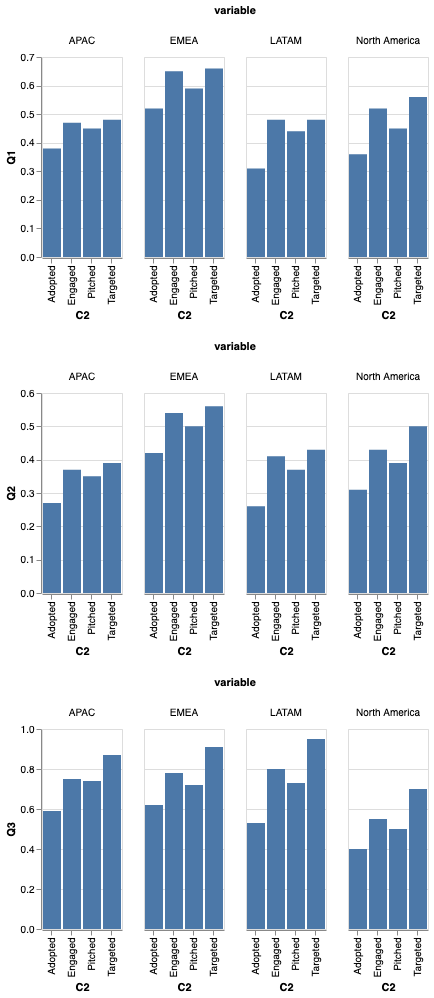

In [12]:
df11 = load_input_table("011.json")

df11 = pd.melt(df11, id_vars=["C1", "C2"], value_vars=["EMEA", "LATAM", "North America", "APAC"])
df11 = df11.pivot_table(index=["variable", "C2"], columns='C1', values='value').reset_index()

print(df11)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "repeat": ["Q1", "Q2", "Q3"],
    "columns": 1,
    "spec": {
        "mark": "bar",
        "encoding": {
            "y": {"field": {"repeat": "repeat"}, "type": "quantitative"},
            "x": { "field": "C2", "type": "nominal" },
            "column": {"field": "variable", "type": "nominal"}      
        }
    }
}, df11)

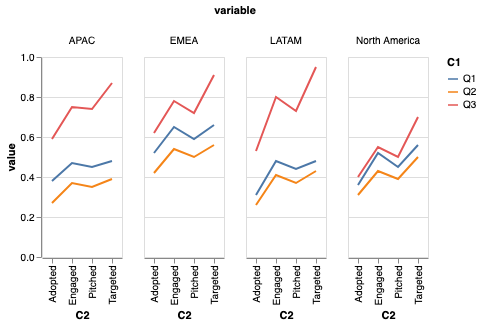

In [13]:
df12 = load_input_table("012.json")

df12 = pd.melt(df12, id_vars=["C1", "C2"], value_vars=["EMEA", "LATAM", "North America", "APAC"])

# print(df12)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "y": {"field": "value", "type": "quantitative"},
        "x": { "field": "C2", "type": "nominal" },
        "column": {"field": "variable", "type": "nominal"},
        "color": {"field": "C1", "type": "nominal"}
    }
}, df12)

    Totals Value variable  value  cumsum
0        7     A    alpha      2       2
1        8     B    alpha      2       2
2        9     c    alpha      3       3
3        9     D    alpha      3       3
4        9     E    alpha      4       4
5        7     A     beta      2       4
6        8     B     beta      3       5
7        9     c     beta      3       6
8        9     D     beta      4       7
9        9     E     beta      3       7
10       7     A    gamma      3       7
11       8     B    gamma      3       8
12       9     c    gamma      3       9
13       9     D    gamma      2       9
14       9     E    gamma      2       9


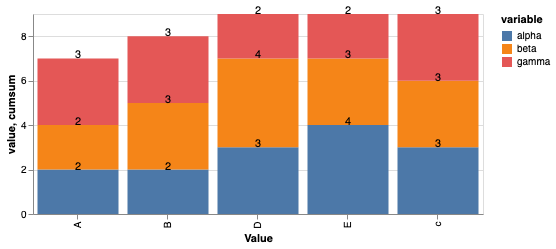

In [14]:
df13 = load_input_table("013.json")

df13 = pd.melt(df13, id_vars=["Totals", "Value"], value_vars=["alpha", "beta", "gamma"])
df13['cumsum'] = df13.groupby("Value")['value'].transform(pd.Series.cumsum)

print(df13)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {"x": { "field": "Value", "type": "nominal" }},
    "layer": [{
        "mark": "bar",
        "encoding": {
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "variable", "type": "nominal"},
            "order": {"field": "variable", "type": "quantitative", "sort": "ascending"}
        }
    },  {
      "mark": "text",
      "encoding": {
        "y": { "field": "cumsum", "type": "quantitative"},
        "text": {"field": "value", "type": "quantitative"}
      }
    }]
}, df13)

    Duration  End of Shift  Period  Shift Start of Shift    s1    s0
0         60  1:50 / 18:10       1      1   0:50 / 19:10   110    50
1         48  4:32 / 15:28       1      2   3:44 / 16:16   272   224
2         40  6:59 / 13:01       1      3   6:19 / 13:41   419   379
3         56  10:01 / 9:59       1      4   9:05 / 10:55   601   545
4         81  14:00 / 6:00       1      5   12:39 / 7:21   840   759
5         48  16:54 / 3:06       1      6   16:06 / 3:54  1014   966
6         62  19:06 / 0:54       1      7   18:04 / 1:56  1146  1084
7         60  1:00 / 19:00       2      8   0:00 / 20:00    60     0
8         88  4:05 / 15:55       2      9   2:37 / 17:23   245   157
9         46  10:04 / 9:56       2     10   9:18 / 10:42   604   558
10        66  12:47 / 7:13       2     11   11:41 / 8:19   767   701
11        83  15:13 / 4:47       2     12   13:50 / 6:10   913   830
12        83  19:00 / 1:00       2     13   17:37 / 2:23  1140  1057
13        37  1:16 / 18:44       3

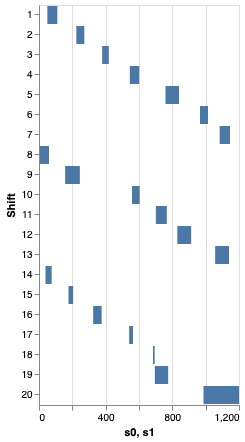

In [20]:
df14 = load_input_table("014.json")

split_col = df14["End of Shift"].str.split("/", expand=True)
df14["s1"] = split_col[0]
split_col = df14["Start of Shift"].str.split("/", expand=True)
df14["s0"] = split_col[0]

df14 = load_and_clean_table(df14)
print(df14)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "s0", "type": "quantitative"},
        "x2": { "field": "s1", "type": "quantitative"},
        "y": { "field": "Shift", "type": "nominal"}
    }
}, df14)

    Duration  End of Shift  Period  Shift Start of Shift    s1    s0
0         60  1:50 / 18:10       1      1   0:50 / 19:10   110    50
1         48  4:32 / 15:28       1      2   3:44 / 16:16   272   224
2         40  6:59 / 13:01       1      3   6:19 / 13:41   419   379
3         56  10:01 / 9:59       1      4   9:05 / 10:55   601   545
4         81  14:00 / 6:00       1      5   12:39 / 7:21   840   759
5         48  16:54 / 3:06       1      6   16:06 / 3:54  1014   966
6         62  19:06 / 0:54       1      7   18:04 / 1:56  1146  1084
7         60  1:00 / 19:00       2      8   0:00 / 20:00    60     0
8         88  4:05 / 15:55       2      9   2:37 / 17:23   245   157
9         46  10:04 / 9:56       2     10   9:18 / 10:42   604   558
10        66  12:47 / 7:13       2     11   11:41 / 8:19   767   701
11        83  15:13 / 4:47       2     12   13:50 / 6:10   913   830
12        83  19:00 / 1:00       2     13   17:37 / 2:23  1140  1057
13        37  1:16 / 18:44       3

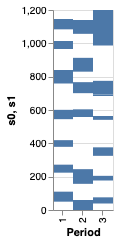

In [38]:
df15 = load_input_table("015.json")

split_col = df15["End of Shift"].str.split("/", expand=True)
df15["s1"] = split_col[0]
split_col = df15["Start of Shift"].str.split("/", expand=True)
df15["s0"] = split_col[0]

df15 = load_and_clean_table(df15)

print(df15)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "rect",
    "encoding": {
        "y": { "field": "s0", "type": "quantitative"},
        "x": { "field": "Period", "type": "nominal"},
        "y2": { "field": "s1", "type": "quantitative"},
    }
}, df15)

   Amount Revenue  Variance Variance %  Year  Year Label         c
0  773000   $773K   39000.0        +5%  2011        2011  812000.0
1  812000   $812K -445000.0       -55%  2012        2012  367000.0
2  367000   $367K  117000.0       +32%  2013        2013  484000.0
3  484000   $484K  278000.0       +57%  2014        2014  762000.0
4  762000   $762K -201000.0       -26%  2015        2015  561000.0
5  561000   $561K  213000.0       +38%  2016        2016  774000.0
6  774000   $774K       NaN             2017        2017       NaN


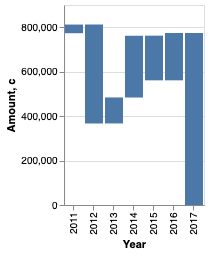

In [59]:
df16 = load_input_table("016.json")

df16["c"] = df16["Amount"] + df16["Variance"]

print(df16)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Year", "type": "nominal"},
    },
    "layer": [{
        "mark": "bar",
        "encoding": {
            "y": { "field": "Amount", "type": "quantitative"},
            "y2": { "field": "c", "type": "quantitative"},
        },
    }]
}, df16)

    Actual  Projected  Year
0   1000.0        NaN  2001
1   1050.0        NaN  2002
2   1110.0        NaN  2003
3   1180.0        NaN  2004
4   1260.0        NaN  2005
5   1350.0        NaN  2006
6   1450.0        NaN  2007
7   1560.0        NaN  2008
8   1680.0        NaN  2009
9   1810.0        NaN  2010
10  1950.0        NaN  2011
11  2100.0        NaN  2012
12  2260.0        NaN  2013
13  2430.0        NaN  2014
14  2610.0        NaN  2015
15  2800.0        NaN  2016
16  3000.0        NaN  2017
17  3210.0     3210.0  2018
18     NaN     4960.0  2025
19     NaN     6510.0  2030
20     NaN    10360.0  2040


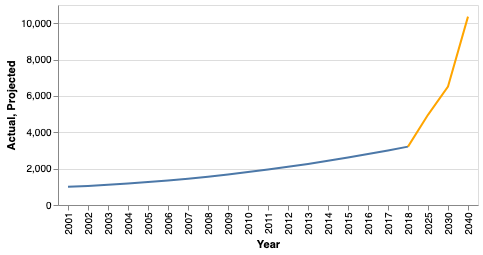

In [68]:
df17 = load_input_table("017.json")

print(df17)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Year", "type": "nominal"},
    },
    "layer": [{
        "mark": "line",
        "encoding": {
            "y": { "field": "Actual", "type": "quantitative"},
        }},{
        "mark": {"type": "line", "color": "orange"},
        "encoding": {
            "y": { "field": "Projected", "type": "quantitative"},
        }
    }]
}, df17)

                 Item variable  value
0   Desktop Computers     2012     20
1             Laptops     2012     34
2            Monitors     2012     12
3            Printers     2012     78
4   Desktop Computers     2013     12
5             Laptops     2013     45
6            Monitors     2013     10
7            Printers     2013     13
8   Desktop Computers     2014     13
9             Laptops     2014     40
10           Monitors     2014     17
11           Printers     2014     90
12  Desktop Computers     2015     12
13            Laptops     2015     39
14           Monitors     2015     15
15           Printers     2015     14


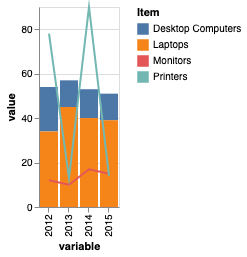

In [81]:
df18 = load_input_table("018.json")

df18 = pd.melt(df18, id_vars='Item', value_vars=["2012", "2013", "2014", "2015"])

print(df18)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "variable", "type": "nominal"},
    },
    "layer": [{
        "mark": "bar",
        "transform": [{"filter": "datum.Item == \"Desktop Computers\" || datum.Item == \"Laptops\""}],
        "encoding": {
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "Item", "type": "nominal"},
        }},{
        "mark": {"type": "line"},
        "transform": [{"filter": "datum.Item != \"Desktop Computers\" && datum.Item != \"Laptops\""}],
        "encoding": {
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "Item", "type": "nominal"},
        }
    }]
}, df18)

              cuts  Customer ID  Duration  Purchase Amount  Representative  \
0     (-0.2, 10.0]          533       533              533             533   
1     (10.0, 20.0]            0         0                0               0   
2     (20.0, 30.0]            0         0                0               0   
3     (30.0, 40.0]            0         0                0               0   
4     (40.0, 50.0]           72        72               72              72   
5     (50.0, 60.0]          118       118              118             118   
6     (60.0, 70.0]          127       127              127             127   
7     (70.0, 80.0]          126       126              126             126   
8     (80.0, 90.0]          123       123              123             123   
9    (90.0, 100.0]          113       113              113             113   
10  (100.0, 110.0]          132       132              132             132   
11  (110.0, 120.0]          115       115              115      

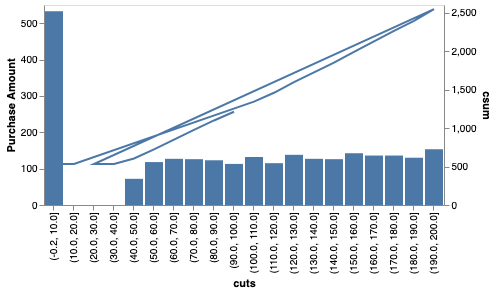

In [126]:
df19 = load_input_table("019.json")

df19["cuts"] = pd.cut(df19['Purchase Amount'], 20)
df19 = df19.groupby(['cuts']).count().reset_index()
df19["csum"] = df19["Purchase Amount"].cumsum()

print(df19)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "cuts", "type": "ordinal", "sort": "none"},
    },
    "layer": [{
        "mark": "bar",
        "encoding": {
            "y": { "field": "Purchase Amount", "type": "quantitative"},
        }
    },{
        "mark": "line",
        "encoding": {
            "y": { "field": "csum", "type": "quantitative"},
        }
    }],
    "resolve": {"scale": {"y": "independent"}}
}, df19)

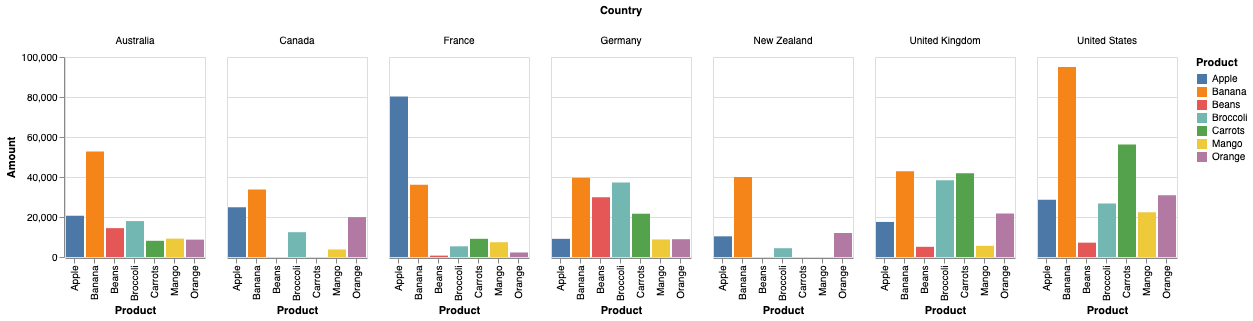

In [139]:
df20 = load_input_table("020.json")

df20 = df20.groupby(['Product', "Country"])["Amount"].sum().reset_index()

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "Product", "type": "nominal"},
        "color": { "field": "Product", "type": "nominal"},
        "y": { "field": "Amount", "type": "quantitative"},
        "column": { "field": "Country", "type": "nominal"},
        
    }
}, df20)

In [ ]:
c